In [1]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.decomposition import PCA
from sklearn.model_selection import (
    cross_val_score,
    StratifiedKFold,
    GridSearchCV
)
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    f1_score,
    accuracy_score,
    precision_recall_curve
)
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import (
    RandomForestClassifier,
    BaggingClassifier,
    AdaBoostClassifier,
    GradientBoostingClassifier
)

In [2]:
train_df = pd.read_csv("./train.csv")
test_df  = pd.read_csv("./test.csv")

# Task 1: EDA (Exploratory Data Analysis).

In [3]:
print('Shape:', train_df.shape)
display(train_df.head())
display(train_df.describe(include='all'))

Shape: (103904, 25)


,Unnamed: 0,id,Gender,Customer Type,Age,Type of Travel,Class,Flight Distance,Inflight wifi service,Departure/Arrival time convenient,...,Inflight entertainment,On-board service,Leg room service,Baggage handling,Checkin service,Inflight service,Cleanliness,Departure Delay in Minutes,Arrival Delay in Minutes,satisfaction
0,0,70172,Male,Loyal Customer,13,Personal Travel,Eco Plus,460,3,4,...,5,4,3,4,4,5,5,25,18.0,neutral or dissatisfied
1,1,5047,Male,disloyal Customer,25,Business travel,Business,235,3,2,...,1,1,5,3,1,4,1,1,6.0,neutral or dissatisfied
2,2,110028,Female,Loyal Customer,26,Business travel,Business,1142,2,2,...,5,4,3,4,4,4,5,0,0.0,satisfied
3,3,24026,Female,Loyal Customer,25,Business travel,Business,562,2,5,...,2,2,5,3,1,4,2,11,9.0,neutral or dissatisfied
4,4,119299,Male,Loyal Customer,61,Business travel,Business,214,3,3,...,3,3,4,4,3,3,3,0,0.0,satisfied


,Unnamed: 0,id,Gender,Customer Type,Age,Type of Travel,Class,Flight Distance,Inflight wifi service,Departure/Arrival time convenient,...,Inflight entertainment,On-board service,Leg room service,Baggage handling,Checkin service,Inflight service,Cleanliness,Departure Delay in Minutes,Arrival Delay in Minutes,satisfaction
count,103904.000000,103904.000000,103904,103904,103904.000000,103904,103904,103904.000000,103904.000000,103904.000000,...,103904.000000,103904.000000,103904.000000,103904.000000,103904.000000,103904.000000,103904.000000,103904.000000,103594.000000,103904
unique,NaN,NaN,2,2,NaN,2,3,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2
top,NaN,NaN,Female,Loyal Customer,NaN,Business travel,Business,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,neutral or dissatisfied
freq,NaN,NaN,52727,84923,NaN,71655,49665,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,58879
mean,51951.500000,64924.210502,NaN,NaN,39.379706,NaN,NaN,1189.448375,2.729683,3.060296,...,3.358158,3.382363,3.351055,3.631833,3.304290,3.640428,3.286351,14.815618,15.178678,NaN
std,29994.645522,37463.812252,NaN,NaN,15.114964,NaN,NaN,997.147281,1.327829,1.525075,...,1.332991,1.288354,1.315605,1.180903,1.265396,1.175663,1.312273,38.230901,38.698682,NaN
min,0.000000,1.000000,NaN,NaN,7.000000,NaN,NaN,31.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN
25%,25975.750000,32533.750000,NaN,NaN,27.000000,NaN,NaN,414.000000,2.000000,2.000000,...,2.000000,2.000000,2.000000,3.000000,3.000000,3.000000,2.000000,0.000000,0.000000,NaN
50%,51951.500000,64856.500000,NaN,NaN,40.000000,NaN,NaN,843.000000,3.000000,3.000000,...,4.000000,4.000000,4.000000,4.000000,3.000000,4.000000,3.000000,0.000000,0.000000,NaN
75%,77927.250000,97368.250000,NaN,NaN,51.000000,NaN,NaN,1743.000000,4.000000,4.000000,...,4.000000,4.000000,4.000000,5.000000,4.000000,5.000000,4.000000,12.000000,13.000000,NaN


In [4]:
# Missing values summary
missing = train_df.isnull().sum().sort_values(ascending=False)
missing = missing[missing > 0]
print('Columns with missing values (count):')
print(missing)

Columns with missing values (count):
Arrival Delay in Minutes    310
dtype: int64


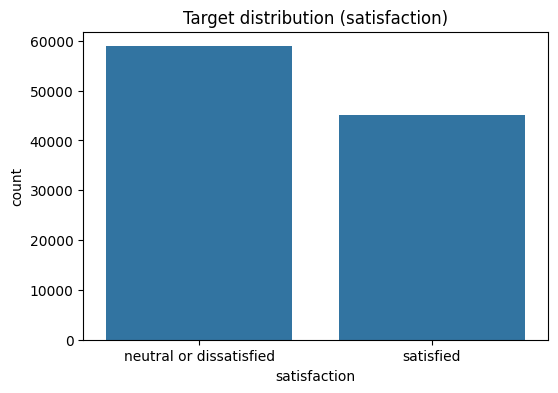

satisfaction
neutral or dissatisfied    58879
satisfied                  45025
Name: count, dtype: int64
Normalized:
satisfaction
neutral or dissatisfied    0.566667
satisfied                  0.433333
Name: proportion, dtype: float64


In [5]:
# Target distribution
plt.figure(figsize=(6,4))
sns.countplot(x='satisfaction', data=train_df)
plt.title('Target distribution (satisfaction)')
plt.show()

print(train_df['satisfaction'].value_counts())
print('Normalized:')
print(train_df['satisfaction'].value_counts(normalize=True))

Categorical columns: ['Gender', 'Customer Type', 'Type of Travel', 'Class', 'satisfaction']


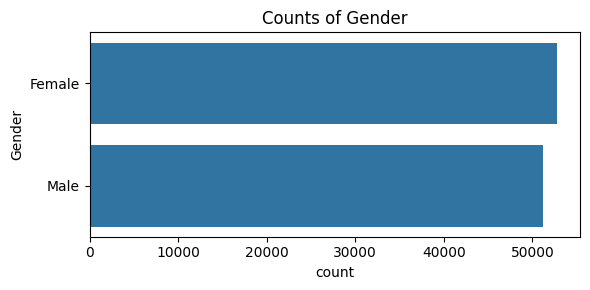

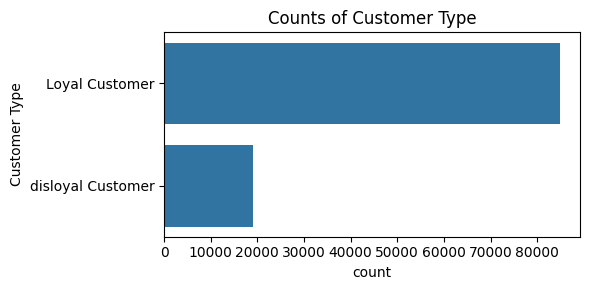

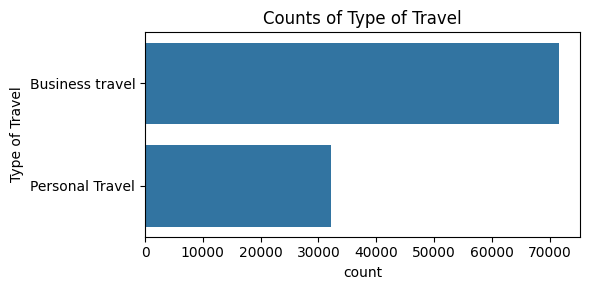

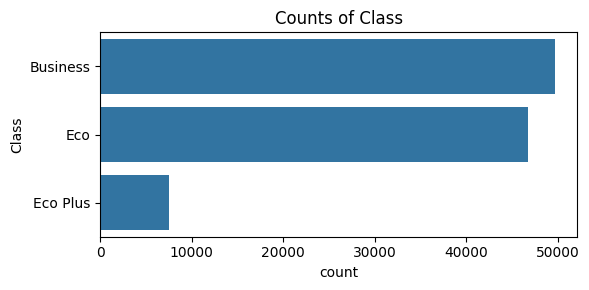

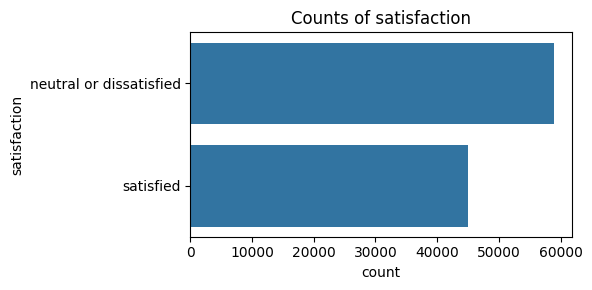

In [6]:
# Categorical columns distribution (if any remain as object)

cat_cols = train_df.select_dtypes(include='object').columns.tolist()
print('Categorical columns:', cat_cols)

for c in cat_cols[:6]:
    plt.figure(figsize=(6,3))
    sns.countplot(
        y=c,
        data=train_df,
        order=train_df[c].value_counts().index
    )
    plt.title(f'Counts of {c}')
    plt.tight_layout()
    plt.show()

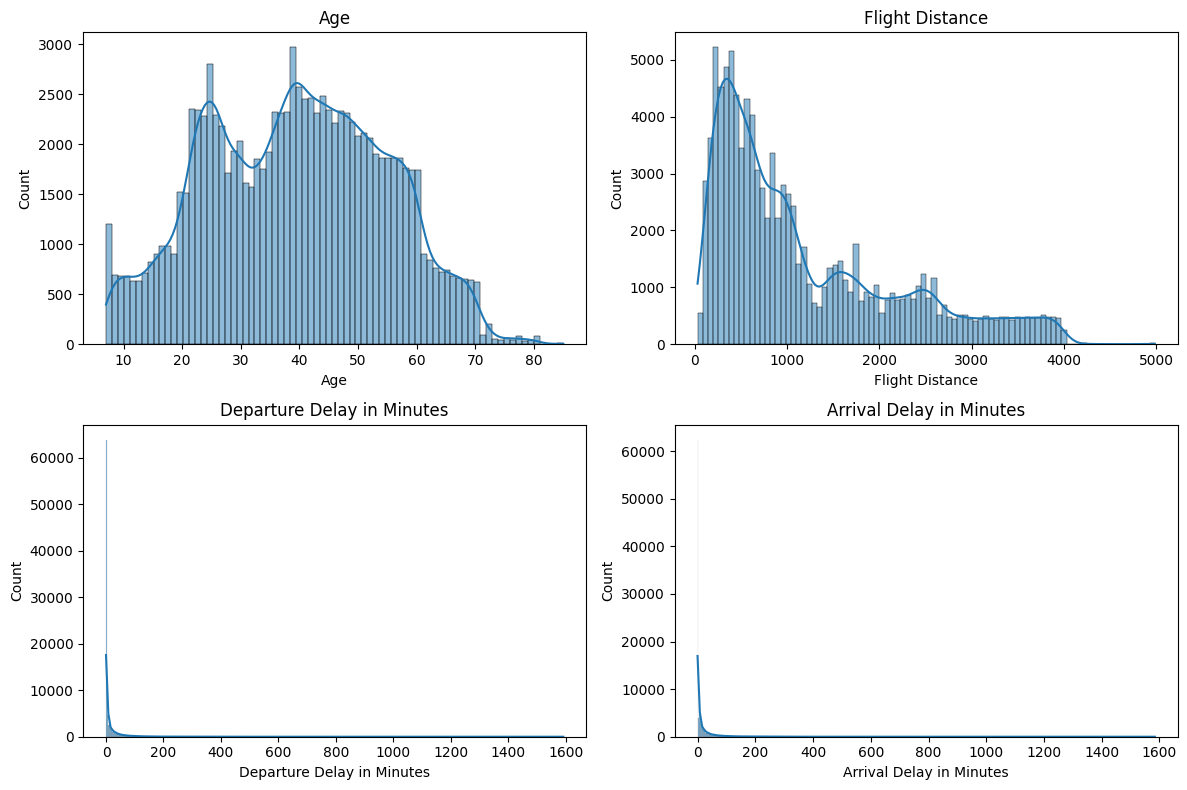

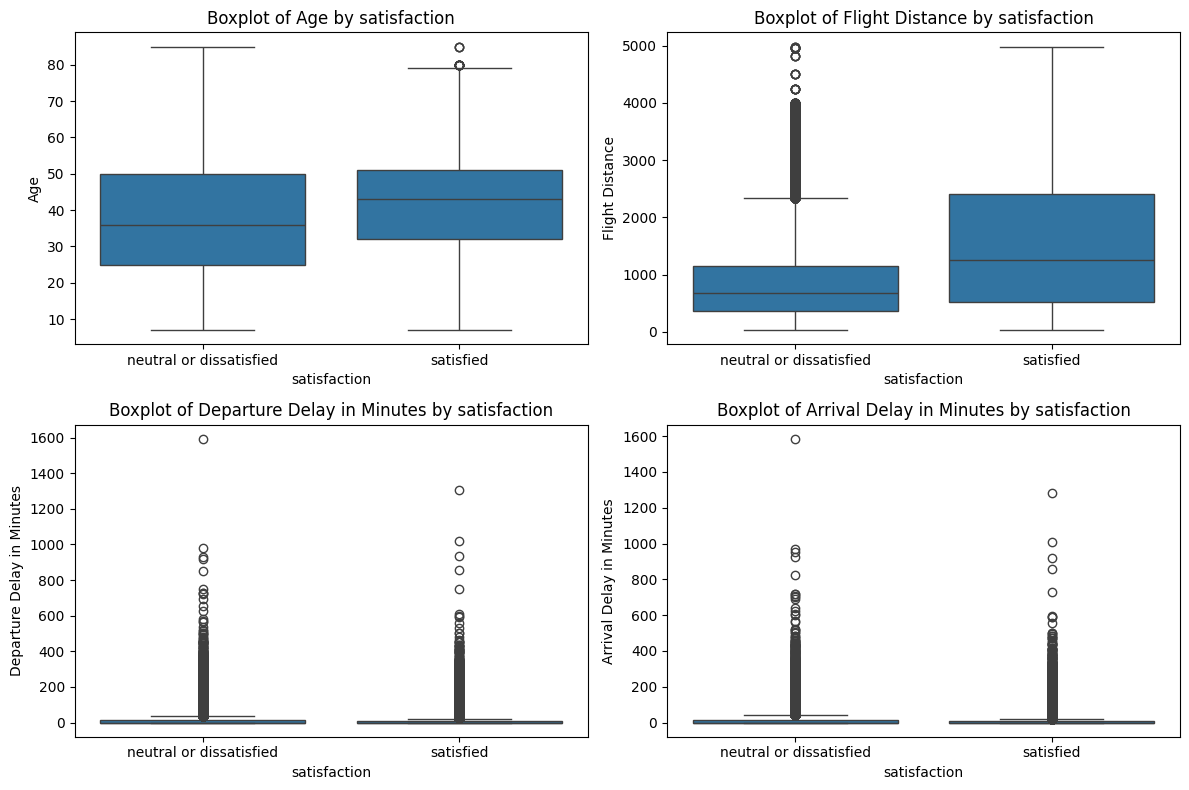

In [7]:
# Numerical distributions and boxplots to check outliers
num_cols = ['Age','Flight Distance','Departure Delay in Minutes','Arrival Delay in Minutes']

plt.figure(figsize=(12,8))
for i, col in enumerate(num_cols, 1):
    plt.subplot(2,2,i)
    sns.histplot(train_df[col].dropna(), kde=True)
    plt.title(col)

plt.tight_layout()
plt.show()

plt.figure(figsize=(12,8))
for i, col in enumerate(num_cols, 1):
    plt.subplot(2,2,i)
    sns.boxplot(x='satisfaction', y=col, data=train_df)
    plt.title(f'Boxplot of {col} by satisfaction')

plt.tight_layout()
plt.show()

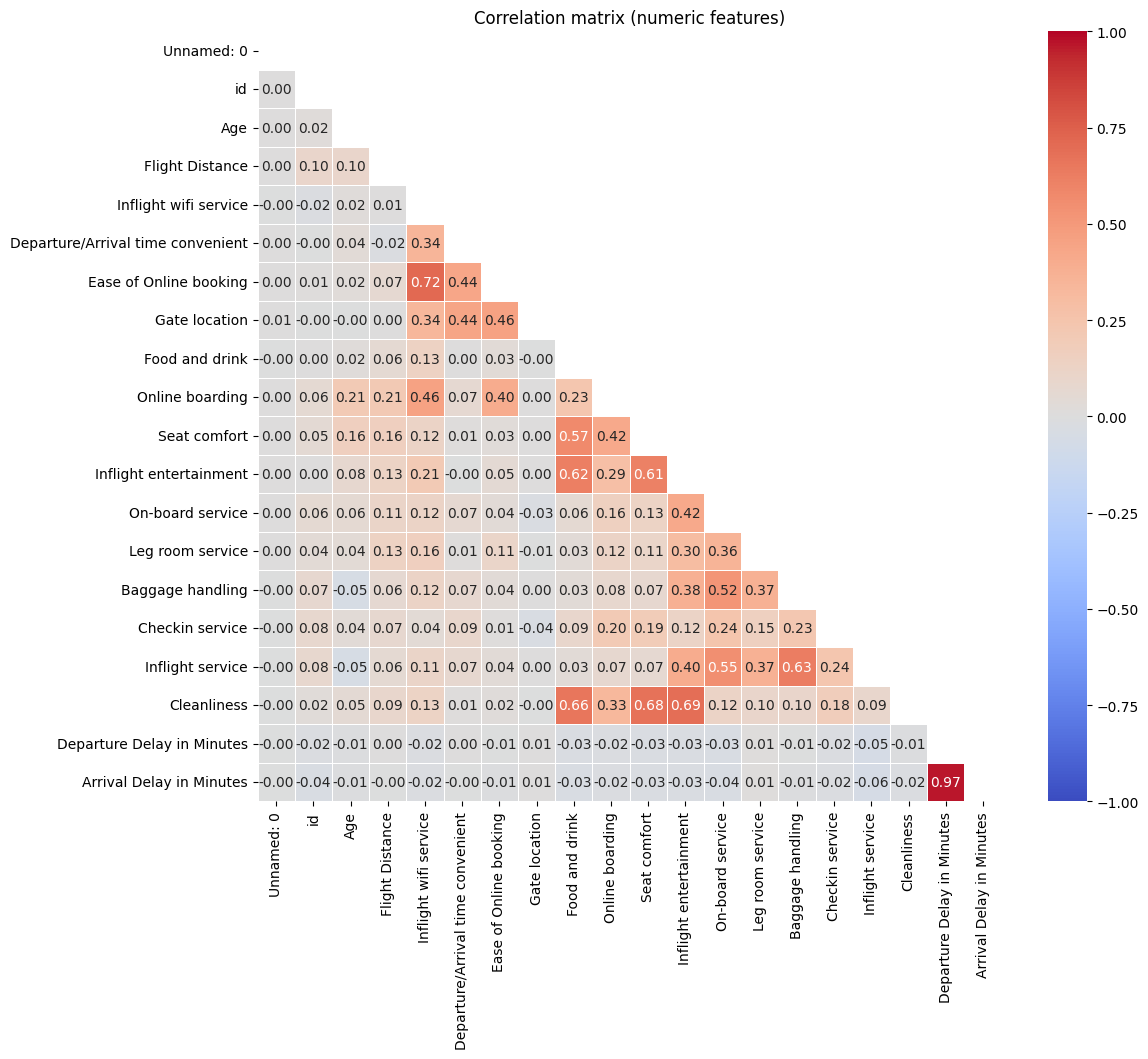

In [8]:
# Correlation heatmap (numeric features) — only numeric columns, handle NaNs and add mask

num_df = train_df.select_dtypes(include=[np.number])

if num_df.shape[1] == 0:
    print('No numeric columns available for correlation')

else:
    corr = num_df.corr()
    if corr.isnull().values.any():
        corr = corr.fillna(0)

    mask = np.triu(np.ones_like(corr, dtype=bool))

    plt.figure(figsize=(12,10))
    sns.heatmap(
        corr,
        annot=True,
        fmt=".2f",
        cmap='coolwarm',
        mask=mask,
        vmax=1.0,
        vmin=-1.0,
        linewidths=.5
    )

    plt.title('Correlation matrix (numeric features)')
    plt.show()

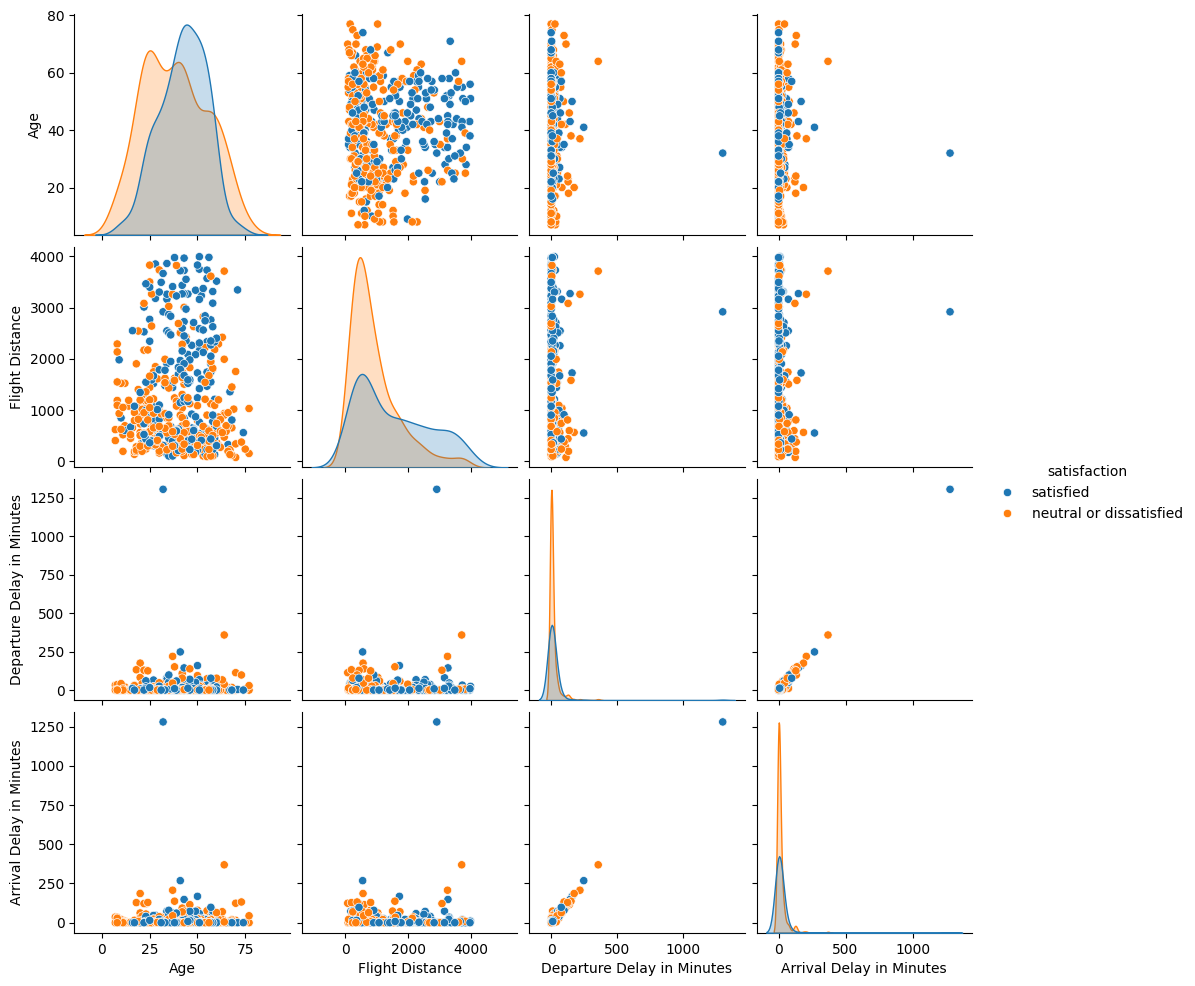

In [9]:
sample = train_df[
    num_cols + ['satisfaction']].dropna().sample(
        min(500, len(train_df)),
        random_state=42
    )

sns.pairplot(sample, hue='satisfaction', diag_kind='kde')
plt.show()

# Task 2: Preprocessing

In [10]:
# Drop unwanted columns
cols_to_drop = ['Unnamed: 0', 'id']
for df_ in [train_df, test_df]:
    df_.drop(
        columns=[c for c in cols_to_drop if c in df_.columns],
        inplace=True
    )

# Mapping categorical values to numbers
target_map = {
    'satisfied': 1,
    'neutral or dissatisfied': 0
}

if 'satisfaction' in train_df.columns:
    train_df['satisfaction'] = train_df['satisfaction'].replace(target_map).astype(int)

# Binary categorical
binary_maps = {
    'Gender': {
        'Male': 1,
        'Female': 0
    },

    'Customer Type': {
        'Loyal Customer': 1,
        'disloyal Customer': 0
    },

    'Type of Travel': {
        'Business travel': 1,
        'Personal Travel': 0
    }
}

for col, m in binary_maps.items():
    if col in train_df.columns:
        train_df[col] = train_df[col].replace(m).astype(int)
        test_df[col] = test_df[col].replace(m).astype(int)

# Ordinal categorical
class_map = {
    'Eco': 0,
    'Eco Plus': 1,
    'Business': 2,
}

if 'Class' in train_df.columns:
    train_df['Class'] = train_df['Class'].replace(class_map).astype(int)
    test_df['Class'] = test_df['Class'].replace(class_map).astype(int)

# Fill missing numeric values with median
num_cols = train_df.select_dtypes(include=[np.number]).columns.tolist()
for c in num_cols:
    median_val = train_df[c].median()
    train_df[c] = train_df[c].fillna(median_val)
    if c in test_df.columns:
        test_df[c] = test_df[c].fillna(median_val)

# Separate X and y
X_train = train_df.drop('satisfaction', axis=1)
y_train = train_df['satisfaction']

if 'satisfaction' in test_df.columns:
    X_test = test_df.drop('satisfaction', axis=1)
    y_test = test_df['satisfaction']

else:
    X_test = test_df.copy()
    y_test = None

# StandardScaler on numeric features
num_cols_X = X_train.select_dtypes(include=[np.number]).columns.tolist()
scaler = StandardScaler()

# fit on train, transform both train and test
X_train[num_cols_X] = scaler.fit_transform(X_train[num_cols_X])
X_test[num_cols_X] = scaler.transform(X_test[num_cols_X])

# Quick summaries
print("Train shape:", X_train.shape, y_train.shape)
print("Test shape:", X_test.shape, None if y_test is None else y_test.shape)
print("Target distribution (train):")
print(y_train.value_counts(normalize=True))

Train shape: (103904, 22) (103904,)
Test shape: (25976, 22) (25976,)
Target distribution (train):
satisfaction
0    0.566667
1    0.433333
Name: proportion, dtype: float64


# Task 3: Extract meaningful features and use them to classify dataset

In [11]:
# Prepare features and target
X_feat = X_train.copy()
y_feat = y_train.astype(int)

print(
    'Train features shape:', X_feat.shape,
    'Train target shape:', y_feat.shape
)

# Base classifier
base_clf = LogisticRegression(max_iter=1000, solver='lbfgs')
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
n_select = min(10, X_feat.shape[1])

# Forward Selection
sfs_fwd = SequentialFeatureSelector(
    base_clf,
    n_features_to_select=n_select,
    direction='forward',
    scoring='f1',
    cv=skf,
    n_jobs=-1
)
sfs_fwd.fit(X_feat, y_feat)
fwd_features = X_feat.columns[sfs_fwd.get_support()].tolist()

print('Forward selected features (n=%d):' % len(fwd_features))
print(fwd_features)

fwd_score = cross_val_score(
    base_clf,
    X_feat[fwd_features],
    y_feat,
    cv=skf,
    scoring='f1',
    n_jobs=-1
)
print('Forward selection F1: %.4f (± %.4f)' % (fwd_score.mean(), fwd_score.std()))

# Backward Elimination
sfs_bwd = SequentialFeatureSelector(
    base_clf,
    n_features_to_select=n_select,
    direction='backward',
    scoring='f1',
    cv=skf,
    n_jobs=-1
)

sfs_bwd.fit(X_feat, y_feat)
bwd_features = X_feat.columns[sfs_bwd.get_support()].tolist()

print('Backward selected features (n=%d):' % len(bwd_features))
print(bwd_features)

bwd_score = cross_val_score(
    base_clf,
    X_feat[bwd_features],
    y_feat,
    cv=skf,
    scoring='f1',
    n_jobs=-1
)
print('Backward selection F1: %.4f (± %.4f)' % (bwd_score.mean(), bwd_score.std()))

# Common features
common = set(fwd_features).intersection(bwd_features)
print('Common features between forward and backward (%d):' % len(common), sorted(common))

# PCA
pca = PCA(
    n_components=0.95,
    random_state=42
)

X_pca = pca.fit_transform(X_feat)
print('Original features:', X_feat.shape[1])
print('PCA components retained:', X_pca.shape[1])

# Evaluate with same base classifier using CV
pca_score = cross_val_score(
    base_clf,
    X_pca,
    y_feat,
    cv=skf,
    scoring='f1',
    n_jobs=-1
)
print('PCA-based F1: %.4f (± %.4f)' % (pca_score.mean(), pca_score.std()))

# Show explained variance ratio top components
print(
    'Explained variance ratio (first 10 components):',
    np.round(pca.explained_variance_ratio_[:10], 4)
)

# Apply feature selection / PCA to test

# Forward selected
X_test_fwd = X_test[fwd_features]

# Backward selected
X_test_bwd = X_test[bwd_features]

# Common selected
X_test_common = X_test[list(common)]

# PCA-transformed test
X_test_pca = pca.transform(X_test)

Train features shape: (103904, 22) Train target shape: (103904,)
Forward selected features (n=10):
['Customer Type', 'Type of Travel', 'Class', 'Inflight wifi service', 'Ease of Online booking', 'Online boarding', 'Inflight entertainment', 'On-board service', 'Leg room service', 'Checkin service']
Forward selection F1: 0.8482 (± 0.0035)
Backward selected features (n=10):
['Customer Type', 'Type of Travel', 'Class', 'Inflight wifi service', 'Departure/Arrival time convenient', 'Online boarding', 'On-board service', 'Leg room service', 'Checkin service', 'Cleanliness']
Backward selection F1: 0.8491 (± 0.0033)
Common features between forward and backward (8): ['Checkin service', 'Class', 'Customer Type', 'Inflight wifi service', 'Leg room service', 'On-board service', 'Online boarding', 'Type of Travel']
Original features: 22
PCA components retained: 17
PCA-based F1: 0.8397 (± 0.0024)
Explained variance ratio (first 10 components): [0.1858 0.1079 0.1001 0.0893 0.0831 0.068  0.0464 0.0438 

# Task 4: Classify with K-Nearest Neighbors (KNN).

In [12]:
# Mapping target in train & test to numeric
target_map = {
    'satisfied': 1,
    'neutral or dissatisfied': 0
}

# Train
y_train = train_df['satisfaction'].replace(target_map).astype('int64')

# Test
if 'satisfaction' in test_df.columns:
    y_test = test_df['satisfaction'].replace(target_map).astype('int64')

else:
    y_test = None

# Feature sets
common_features = [
    'Checkin service',
    'Class',
    'Customer Type',
    'Inflight wifi service',
    'Leg room service',
    'On-board service',
    'Online boarding',
    'Type of Travel'
]

backward_features = [
    'Customer Type',
    'Type of Travel',
    'Class',
    'Inflight wifi service',
    'Departure/Arrival time convenient',
    'Online boarding',
    'On-board service',
    'Leg room service',
    'Checkin service','Cleanliness'
]

# KNN evaluation function
def evaluate_knn_train_test(
    X_train,
    y_train,
    X_test,
    y_test,
    feature_list,
    k=5
):
    print('--- Evaluating KNN (k=%d) on %d features ---' % (k, len(feature_list)))
    
    X_train_sub = X_train[feature_list]
    X_test_sub = X_test[feature_list]
    
    clf = KNeighborsClassifier(n_neighbors=k, n_jobs=-1)
    clf.fit(X_train_sub, y_train)
    
    y_pred = clf.predict(X_test_sub)
    
    print('Test accuracy:', accuracy_score(y_test, y_pred))
    print('Test F1:', f1_score(y_test, y_pred))
    print('Classification report:')
    print(classification_report(y_test, y_pred, digits=4))
    print('Confusion matrix:\n', confusion_matrix(y_test, y_pred))
    
    return clf

# Performing an evaluation on a set of features
print('Evaluating common features:')
clf_common = evaluate_knn_train_test(
    X_train,
    y_train,
    X_test,
    y_test,
    common_features,
    k=5
)

print('Evaluating backward-selected features:')
clf_bwd = evaluate_knn_train_test(
    X_train,
    y_train,
    X_test,
    y_test,
    backward_features,
    k=5
)

Evaluating common features:
--- Evaluating KNN (k=5) on 8 features ---
Test accuracy: 0.9324376347397598
Test F1: 0.9215922798552473
Classification report:
              precision    recall  f1-score   support

           0     0.9274    0.9543    0.9406     14573
           1     0.9393    0.9045    0.9216     11403

    accuracy                         0.9324     25976
   macro avg     0.9334    0.9294    0.9311     25976
weighted avg     0.9326    0.9324    0.9323     25976

Confusion matrix:
 [[13907   666]
 [ 1089 10314]]
Evaluating backward-selected features:
--- Evaluating KNN (k=5) on 10 features ---
Test accuracy: 0.9352094240837696
Test F1: 0.9247552197433719
Classification report:
              precision    recall  f1-score   support

           0     0.9293    0.9573    0.9431     14573
           1     0.9433    0.9070    0.9248     11403

    accuracy                         0.9352     25976
   macro avg     0.9363    0.9321    0.9339     25976
weighted avg     0.9354    

# Task 5: Find optimal K.

=== Grid search for common_features (features=8) ===
Best k (CV) for common_features: 11 CV F1 = 0.9179


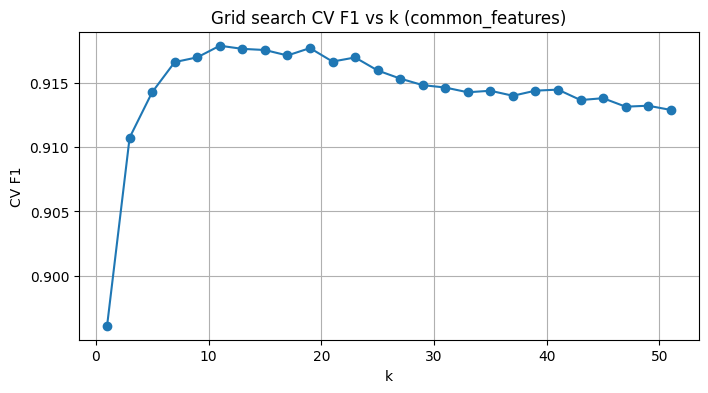

Test accuracy: 0.9332075762242069
Test F1: 0.9225688400946133
Classification report:
              precision    recall  f1-score   support

           0     0.9287    0.9542    0.9413     14573
           1     0.9393    0.9064    0.9226     11403

    accuracy                         0.9332     25976
   macro avg     0.9340    0.9303    0.9319     25976
weighted avg     0.9334    0.9332    0.9331     25976

Confusion matrix:
[[13905   668]
 [ 1067 10336]]
=== Grid search for backward_features (features=10) ===
Best k (CV) for backward_features: 9 CV F1 = 0.9191


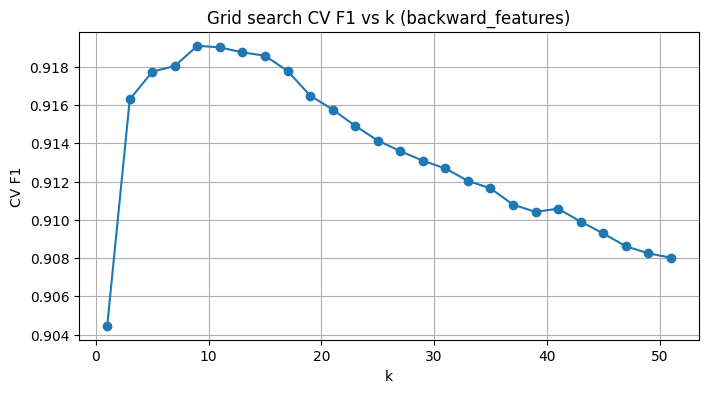

Test accuracy: 0.9337850323375424
Test F1: 0.9232690935046396
Classification report:
              precision    recall  f1-score   support

           0     0.9295    0.9544    0.9418     14573
           1     0.9396    0.9075    0.9233     11403

    accuracy                         0.9338     25976
   macro avg     0.9346    0.9309    0.9325     25976
weighted avg     0.9339    0.9338    0.9336     25976

Confusion matrix:
[[13908   665]
 [ 1055 10348]]


In [13]:
# Target mapping (train & test)
target_map = {
    'satisfied': 1,
    'neutral or dissatisfied': 0
}

y_train_num = train_df['satisfaction'].replace(target_map).astype(int)
y_test_num = test_df['satisfaction'].replace(target_map).astype(int)


# Feature sets
common_features = [
    'Checkin service',
    'Class',
    'Customer Type',
    'Inflight wifi service',
    'Leg room service',
    'On-board service',
    'Online boarding',
    'Type of Travel'
]

backward_features = [
    'Customer Type',
    'Type of Travel',
    'Class',
    'Inflight wifi service',
    'Departure/Arrival time convenient',
    'Online boarding',
    'On-board service',
    'Leg room service',
    'Checkin service','Cleanliness'
]

# Grid search & evaluation function
ks = list(range(1,52,2))
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

def grid_search_and_eval_train_test(
    X_train,
    y_train,
    X_test,
    y_test,
    features,
    name
):
    print(f'=== Grid search for {name} (features={len(features)}) ===')
    X_sub_train = X_train[features]
    X_sub_test = X_test[features]

    param_grid = {'n_neighbors': ks}
    grid = GridSearchCV(
        KNeighborsClassifier(),
        param_grid,
        scoring='f1',
        cv=cv,
        n_jobs=-1
    )
    grid.fit(X_sub_train, y_train)

    best_k = grid.best_params_['n_neighbors']
    best_score = grid.best_score_
    print(f'Best k (CV) for {name}:', best_k, 'CV F1 =', round(best_score,4))

    # extract mean test scores for plotting
    mean_scores = []
    for k in ks:
        idx = list(grid.cv_results_['params']).index({'n_neighbors': k})
        mean_scores.append(grid.cv_results_['mean_test_score'][idx])

    plt.figure(figsize=(8,4))
    plt.plot(ks, mean_scores, marker='o')
    plt.xlabel('k')
    plt.ylabel('CV F1')
    plt.title(f'Grid search CV F1 vs k ({name})')
    plt.grid(True)
    plt.show()

    # evaluate on hold-out test set
    clf = KNeighborsClassifier(n_neighbors=best_k)
    clf.fit(X_sub_train, y_train)
    y_pred = clf.predict(X_sub_test)

    print('Test accuracy:', accuracy_score(y_test, y_pred))
    print('Test F1:', f1_score(y_test, y_pred))
    print('Classification report:')
    print(classification_report(y_test, y_pred, digits=4))
    print('Confusion matrix:')
    print(confusion_matrix(y_test, y_pred))
    return best_k, best_score

# Run grid search and evaluation on both feature sets
best_k_common, best_score_common = grid_search_and_eval_train_test(
    train_df,
    y_train_num,
    test_df,
    y_test_num,
    common_features,
    'common_features'
)

best_k_bwd, best_score_bwd = grid_search_and_eval_train_test(
    train_df,
    y_train_num,
    test_df,
    y_test_num,
    backward_features,
    'backward_features'
)

# Task 6: Classify with Decision Tree Classifier with ID3, C4.5

In [14]:
# Ensure target is numeric
target_map = {
    'satisfied': 1,
    'neutral or dissatisfied': 0
}

y_train_num = train_df['satisfaction'].replace(target_map).astype(int)
y_test_num = test_df['satisfaction'].replace(target_map).astype(int)

# Feature sets
sets = {
    'common': common_features,
    'backward': backward_features
}

results = {}

for name, feats in sets.items():
    print('='*60)
    print(f'Feature set: {name} (n_features={len(feats)})')

    X_train_sub = train_df[feats].copy()
    X_test_sub = test_df[feats].copy()

    # ID3 — Entropy, no pruning
    id3 = DecisionTreeClassifier(
        criterion='entropy',
        random_state=42
    )
    id3.fit(X_train_sub, y_train_num)
    y_pred_id3 = id3.predict(X_test_sub)

    print('\nID3 Results:')
    print(' Accuracy:', accuracy_score(y_test_num, y_pred_id3))
    print(' F1-score:', f1_score(y_test_num, y_pred_id3))
    print(' Confusion Matrix:\n', confusion_matrix(y_test_num, y_pred_id3))
    print(classification_report(y_test_num, y_pred_id3, digits=4))

    results[(name, 'ID3')] = {
        'model': id3,
        'accuracy': accuracy_score(y_test_num, y_pred_id3),
        'f1': f1_score(y_test_num, y_pred_id3)
    }

    # C4.5-like — Entropy + Pruning
    c45 = DecisionTreeClassifier(
        criterion='entropy',
        max_depth=8,
        min_samples_leaf=20,
        random_state=42
    )
    c45.fit(X_train_sub, y_train_num)
    y_pred_c45 = c45.predict(X_test_sub)

    print('\nC4.5-like Results:')
    print(' Accuracy:', accuracy_score(y_test_num, y_pred_c45))
    print(' F1-score:', f1_score(y_test_num, y_pred_c45))
    print(' Confusion Matrix:\n', confusion_matrix(y_test_num, y_pred_c45))
    print(classification_report(y_test_num, y_pred_c45, digits=4))

    results[(name, 'C4.5-like')] = {
        'model': c45,
        'accuracy': accuracy_score(y_test_num, y_pred_c45),
        'f1': f1_score(y_test_num, y_pred_c45)
    }

Feature set: common (n_features=8)

ID3 Results:
 Accuracy: 0.9406760086233447
 F1-score: 0.9315263274827816
 Confusion Matrix:
 [[13953   620]
 [  921 10482]]
              precision    recall  f1-score   support

           0     0.9381    0.9575    0.9477     14573
           1     0.9442    0.9192    0.9315     11403

    accuracy                         0.9407     25976
   macro avg     0.9411    0.9383    0.9396     25976
weighted avg     0.9407    0.9407    0.9406     25976


C4.5-like Results:
 Accuracy: 0.9254311672312904
 F1-score: 0.9161725883931277
 Confusion Matrix:
 [[13454  1119]
 [  818 10585]]
              precision    recall  f1-score   support

           0     0.9427    0.9232    0.9328     14573
           1     0.9044    0.9283    0.9162     11403

    accuracy                         0.9254     25976
   macro avg     0.9235    0.9257    0.9245     25976
weighted avg     0.9259    0.9254    0.9255     25976

Feature set: backward (n_features=10)

ID3 Results:
 Ac

# Task 7: Classify with Bagging / Boosting methods

In [15]:
# Ensure target is numeric
target_map = {
    'satisfied': 1,
    'neutral or dissatisfied': 0
}

y_train_num = train_df['satisfaction'].replace(target_map).astype(int)
y_test_num = test_df['satisfaction'].replace(target_map).astype(int)

# Feature sets
sets = {'common': common_features, 'backward': backward_features}

# Ensemble models
models = {
    'RandomForest': RandomForestClassifier(
        n_estimators=100,
        random_state=42,
        n_jobs=-1
    ),
    'BaggingDT': BaggingClassifier(
        estimator=DecisionTreeClassifier(random_state=42),
        n_estimators=50,
        random_state=42,
        n_jobs=-1
    ),
    'AdaBoost': AdaBoostClassifier(
        n_estimators=50,
        random_state=42
    ),
    'GradientBoosting': GradientBoostingClassifier(
        n_estimators=100,
        random_state=42
    )
}

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
results_ens = {}

for set_name, feats in sets.items():
    print('=== Feature set:', set_name, '(%d features)' % len(feats))
    X_train_sub = train_df[feats].copy()
    X_test_sub = test_df[feats].copy()
    y_train_sub = y_train_num.copy()
    y_test_sub = y_test_num.copy()
    
    for mname, m in models.items():
        print('-- Model:', mname)
        m.fit(X_train_sub, y_train_sub)
        y_pred = m.predict(X_test_sub)
        
        acc = accuracy_score(y_test_sub, y_pred)
        f1 = f1_score(y_test_sub, y_pred)
        print(' Test acc: %.4f  Test F1: %.4f' % (acc, f1))
        print(classification_report(y_test_sub, y_pred, digits=4))
        print('Confusion matrix:\n', confusion_matrix(y_test_sub, y_pred))
        
        # CV F1 (5-fold) on train set for robustness
        try:
            cv_scores = cross_val_score(
                m,
                X_train_sub,
                y_train_sub,
                cv=skf,
                scoring='f1',
                n_jobs=-1
            )
            print(' CV F1 (train): %.4f (± %.4f)' % (cv_scores.mean(), cv_scores.std()))

        except Exception as e:
            print(' CV scoring failed:', e)
        
        results_ens[(set_name, mname)] = {'acc': acc, 'f1': f1}

=== Feature set: common (8 features)
-- Model: RandomForest
 Test acc: 0.9414  Test F1: 0.9326
              precision    recall  f1-score   support

           0     0.9409    0.9556    0.9482     14573
           1     0.9421    0.9233    0.9326     11403

    accuracy                         0.9414     25976
   macro avg     0.9415    0.9394    0.9404     25976
weighted avg     0.9414    0.9414    0.9413     25976

Confusion matrix:
 [[13926   647]
 [  875 10528]]
 CV F1 (train): 0.9290 (± 0.0028)
-- Model: BaggingDT
 Test acc: 0.9406  Test F1: 0.9318
              precision    recall  f1-score   support

           0     0.9412    0.9538    0.9474     14573
           1     0.9399    0.9238    0.9318     11403

    accuracy                         0.9406     25976
   macro avg     0.9405    0.9388    0.9396     25976
weighted avg     0.9406    0.9406    0.9405     25976

Confusion matrix:
 [[13899   674]
 [  869 10534]]
 CV F1 (train): 0.9283 (± 0.0024)
-- Model: AdaBoost
 Test acc

# Task 9: enhance performance of your models

In [16]:
# Prepare features and numeric target
target_map = {
    'satisfied': 1,
    'neutral or dissatisfied': 0
}

y_train_num = train_df['satisfaction'].replace(target_map).astype(int)
y_test_num = test_df['satisfaction'].replace(target_map).astype(int)

X_train_sub = train_df[backward_features].copy()
X_test_sub = test_df[backward_features].copy()

# Hyperparameter tuning with class balancing
rf = RandomForestClassifier(random_state=42)

param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_leaf': [1, 5, 10],
    'class_weight': [None, 'balanced']
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

grid = GridSearchCV(
    rf,
    param_grid,
    scoring='f1',
    cv=cv,
    n_jobs=-1
)

grid.fit(X_train_sub, y_train_num)

best_rf = grid.best_estimator_

print('Best hyperparameters:')
print(grid.best_params_)
print('Best CV F1-score:', round(grid.best_score_, 4))

# Evaluation on test set with default threshold (0.5)
y_pred_default = best_rf.predict(X_test_sub)

print('\nEvaluation with default threshold (0.5):')
print('Accuracy:', accuracy_score(y_test_num, y_pred_default))
print('F1-score:', f1_score(y_test_num, y_pred_default))
print('Confusion matrix:\n', confusion_matrix(y_test_num, y_pred_default))
print(classification_report(y_test_num, y_pred_default, digits=4))

# Threshold tuning to maximize F1-score
y_probs = best_rf.predict_proba(X_test_sub)[:, 1]

precisions, recalls, thresholds = precision_recall_curve(y_test_num, y_probs)
f1_scores = (2 * precisions * recalls) / (precisions + recalls + 1e-9)

best_idx = np.argmax(f1_scores[:-1])
best_threshold = thresholds[best_idx]

y_pred_tuned = (y_probs >= best_threshold).astype(int)

print('\nEvaluation with tuned threshold:')
print('Best threshold:', round(best_threshold, 4))
print('F1-score (tuned):', f1_score(y_test_num, y_pred_tuned))
print('Confusion matrix:\n', confusion_matrix(y_test_num, y_pred_tuned))
print(classification_report(y_test_num, y_pred_tuned, digits=4))

Best hyperparameters:
{'class_weight': 'balanced', 'max_depth': None, 'min_samples_leaf': 5, 'n_estimators': 200}
Best CV F1-score: 0.9423

Evaluation with default threshold (0.5):
Accuracy: 0.9513396981829381
F1-score: 0.9443318946533956
Confusion matrix:
 [[13991   582]
 [  682 10721]]
              precision    recall  f1-score   support

           0     0.9535    0.9601    0.9568     14573
           1     0.9485    0.9402    0.9443     11403

    accuracy                         0.9513     25976
   macro avg     0.9510    0.9501    0.9506     25976
weighted avg     0.9513    0.9513    0.9513     25976


Evaluation with tuned threshold:
Best threshold: 0.5231
F1-score (tuned): 0.9446233949609496
Confusion matrix:
 [[14017   556]
 [  699 10704]]
              precision    recall  f1-score   support

           0     0.9525    0.9618    0.9572     14573
           1     0.9506    0.9387    0.9446     11403

    accuracy                         0.9517     25976
   macro avg     0.951